# Майнор "Интеллектуальный анализ данных"

# Курс "Прикладные задачи анализа данных"

## Лабораторная работа №2. RecSys

В рамках данной лабораторной работы вам предлагается решить задачу рекомендательной системы на основе следующих данных:

* **rating.csv** - рейтинги аниме по 10 бальной шкале
* **anime.csv** - описание items

Скачать данные можно [здесь](https://drive.google.com/drive/u/1/folders/1FarHUuqQq4tQSlERB9K8uEfZAZT9tQWv)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

## Данные

Данные содержат информацию об предподчтениях 73,516 пользователей в 12,294 аниме. Каждый пользователь может добавить аниме и выставить рейтниг.

Anime.csv

* anime_id - идентификатор аниме (items)
* name - полное название аниме
* genre - категория/категории для аниме (разделены запятой).
* type - тип: movie, TV, OVA, etc.
* episodes - количество эпизодов (для экранизаций)
* rating - средний рейтинг по аниме.
* members - количество членов коммьюнити к аниме

Rating.csv

* user_id - идентификатор пользователя (users)
* anime_id - идентификатор аниме
* rating - рейтинг пользователя по аниме (-1 пользователь смотрел, но не оставил рейтинг).

In [3]:
adata = pd.read_csv('/content/drive/MyDrive/Lab#2/anime.csv') 
rdata = pd.read_csv('/content/drive/MyDrive/Lab#2/rating.csv')

## Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)

Доля просмотренных, но не оценённых аниме

In [4]:
len(rdata[rdata['rating'] == -1]) / len(rdata)

0.18896156858107716

Разреженность

In [5]:
1 - len(rdata) / (len(rdata['user_id'].value_counts()) * len(rdata['anime_id'].value_counts()))

0.9905100307517416

### Вывод

Даные - плотны.

## Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий
* Разпределение числа "айтемов" по количеству взаимодействий
* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"
* и т.д. (бонус)

Будем называть явным взаимодействием - оценку аниме, а неявным - просмотр без оценки(т.е. -1 в rating). Общее взаимодействие - какое либо(явное или неявное) взаимодействие.

In [6]:
im_rdata = rdata[rdata['rating'] == -1]
ex_rdata = rdata[rdata['rating'] != -1]

### Распределение числа пользователей по количеству взаимодействий

Общее

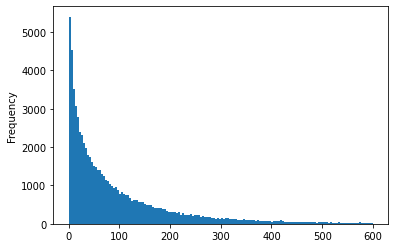

In [7]:
rdata['user_id'].value_counts().plot.hist(bins=150, range=[0, 600])

Явное


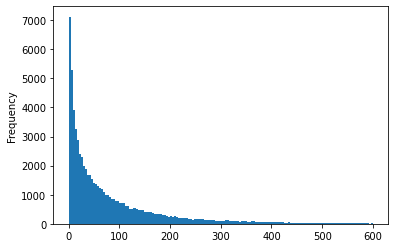

In [8]:
ex_rdata['user_id'].value_counts().plot.hist(bins=150, range=[0, 600])

Неявное

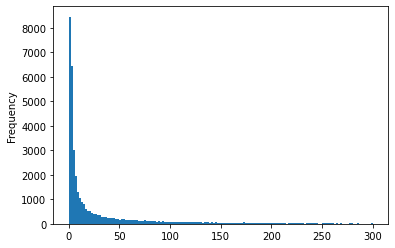

In [9]:
im_rdata['user_id'].value_counts().plot.hist(bins=150, range=[0, 300])

In [10]:
len(im_rdata) / len(ex_rdata)

0.23298719426955675

### Раcпределение числа "айтемов" по количеству взаимодействий

Общее

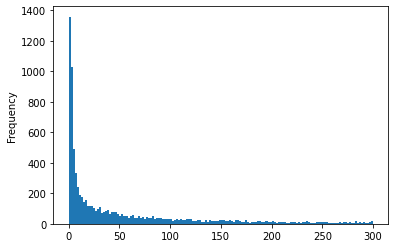

In [11]:
rdata['anime_id'].value_counts().plot.hist(bins=150, range=[0, 300])

Явное


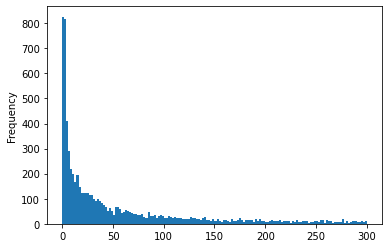

In [12]:
ex_rdata['anime_id'].value_counts().plot.hist(bins=150, range=[0, 300])

Неявное

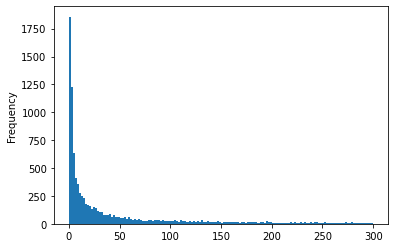

In [13]:
im_rdata['anime_id'].value_counts().plot.hist(bins=150, range=[0, 300])

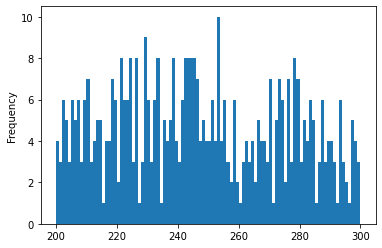

In [14]:
im_rdata['anime_id'].value_counts().plot.hist(bins=100, range=[200, 300])

### Распределение рейтингов

По количеству пользователей

In [15]:
for i in [-1] + [i for i in range(1, 11)]:
  print(i, len(rdata[rdata['rating'] == i]['user_id'].unique()))

-1 37128
1 6038
2 8486
3 11828
4 21788
5 34554
6 46396
7 55881
8 60462
9 62164
10 62029


По количеству аниме

In [16]:
for i in [-1] + [i for i in range(1, 11)]:
  print(i, len(rdata[rdata['rating'] == i]['anime_id'].unique()))

-1 10697
1 3981
2 4495
3 5884
4 7015
5 8224
6 8414
7 8352
8 7787
9 7030
10 6845


### Распределение средних рейтингов

По количеству аниме.

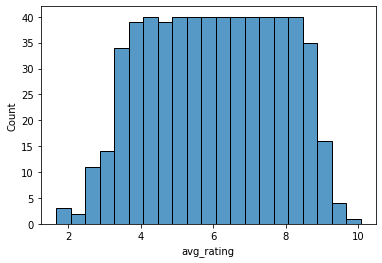

In [17]:
import seaborn as sns
sns.histplot(data=adata['rating'].value_counts().rename_axis('avg_rating').reset_index(name='count').sort_values(by=['avg_rating']), x='avg_rating', binwidth=0.4)

По количеству пользователей

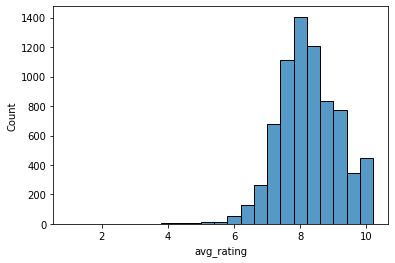

In [18]:
import random
sns.histplot(data=pd.DataFrame([[i, ex_rdata[ex_rdata['user_id'] == i]['rating'].mean()] for i in random.sample(ex_rdata['user_id'].unique().tolist(),7300)], columns=['user_id', 'avg_rating']), x='avg_rating', binwidth=0.4)


### Вывод

Пользователи склонны ставить очень высокие оценки(7-10). Но при этом, у большинства аниме оценки достаточно средненькие(4-8).
Это связанно с тем, что популярные аниме получают только высокие оценки, а непопулярные средние и низкие. В общем то, так оно и должно быть. 

### Предобработка

Удалим просмотры без оценок

In [19]:
data = ex_rdata

Отберём юзеров с 5 и более оценками.

In [20]:
rate_count = data['user_id'].value_counts().rename_axis('user_id').reset_index(name='count')
filtered_users = rate_count[rate_count['count'] >= 5]

## Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

In [90]:
%%time
train = pd.DataFrame()
test = pd.DataFrame()
for user in filtered_users.index.unique()[:]:
    temp_table = data[data.user_id == user]
    cnt = temp_table.shape[0]
    size_train = round(cnt*0.7, 0)
    train = train.append(temp_table.sort_values(by='rating', ascending=False).iloc[:int(size_train)])
    test = test.append(temp_table.sort_values(by='rating', ascending=False).iloc[int(size_train):])

CPU times: user 36min 53s, sys: 1min 17s, total: 38min 10s
Wall time: 33min 20s


In [92]:
print('dataset train ', train.shape[0], ' test', test.shape[0])
print('unique user in train', train.user_id.nunique(), 'test ', test.user_id.nunique())
print('cold-user in the test ', test.user_id.nunique() - test[test.user_id.isin(train.user_id)].user_id.nunique())

dataset train  3751688  test 1607799
unique user in train 57769 test  55084
cold-user in the test  0


In [93]:
test_group = test.sort_values(by='rating', ascending=False).groupby('user_id')['anime_id'].apply(lambda x: list(x)).to_frame().reset_index()

## Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

### 10 самых лучших аниме из 500 самых популярных.

members более 100000 имеют немногим более 500 аниме. Пробуем отобрать из 10 с максимальным средним рейтингом.

In [55]:
popular_anime = adata[adata['members'] > 100000].sort_values(by='rating', ascending=False)['anime_id'].tolist()[:10]

predict_frame = test_group.copy()
predict_frame['pred'] = [popular_anime] * len(test_group)

Metrics.add_tops(predict_frame)
Metrics.print_score(predict_frame)

,MRR,MAP@K,NDCG@K
top5,0.00708697,0.00708697,0.0137337
top10,0.0120061,0.0119718,0.0257627
top25,0.0166528,0.0164569,0.0347288


### 10 самых популярных аниме


In [56]:
popular_anime = adata.sort_values(by='members', ascending=False)['anime_id'].tolist()[:10]

predict_frame = test_group.copy()
predict_frame['pred'] = [popular_anime] * len(test_group)

Metrics.add_tops(predict_frame)
Metrics.print_score(predict_frame)

,MRR,MAP@K,NDCG@K
top5,0.0640435,0.0638994,0.0949087
top10,0.106742,0.102378,0.166151
top25,0.144019,0.136319,0.2178


### 10 самых рейтинговых аниме

In [57]:
popular_anime = adata.sort_values(by='rating', ascending=False)['anime_id'].tolist()[:10]

predict_frame = test_group.copy()
predict_frame['pred'] = [popular_anime] * len(test_group)

Metrics.add_tops(predict_frame)
Metrics.print_score(predict_frame)

,MRR,MAP@K,NDCG@K
top5,0.000111782,0.000111782,0.000223564
top10,0.00306282,0.00306282,0.00756737
top25,0.00425729,0.0042635,0.0104481


### 10 рандомных аниме

In [71]:
popular_anime = random.sample(adata['anime_id'].tolist() ,10)

predict_frame = test_group.copy()
predict_frame['pred'] = [popular_anime] * len(test_group)

Metrics.add_tops(predict_frame)
Metrics.print_score(predict_frame)

,MRR,MAP@K,NDCG@K
top5,0.000111782,0.000111782,0.000223564
top10,0.000766947,0.000766947,0.00173127
top25,0.00133207,0.00133207,0.00308195


### Вывод

Результат плохой. Лучше всего(на 2 порядка лучше рандома) себя показали аниме с наибольшим комьюнити. Остальные 2 случая опередили рандом всего лишь на 1 порядок.

## Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

* Реализовать один из методов коллоборативной фильтрации SVD, SVD++, ALS, ALS with implicit feedback

### ALS

In [58]:
from scipy.sparse import csr_matrix
#!pip install implicit
from implicit.als import AlternatingLeastSquares

In [95]:
rating = list(train.rating)

user_id = {v: k for k, v in enumerate(train['user_id'].unique())}
item_id = {v: k for k, v in enumerate(train['anime_id'].unique())}
rows = train['user_id'].map(user_id)
cols = train['anime_id'].map(item_id)

rating_sparse = csr_matrix((rating, (rows, cols)), shape=(len(train['user_id'].unique()), len(train['anime_id'].unique())) )

ALS = AlternatingLeastSquares(factors=5, regularization=0.05)
ALS.fit(rating_sparse.T)
predict = ALS.recommend_all(rating_sparse, filter_already_liked_items=True )

In [96]:
predict_frame = test_group.copy()
predict_frame['pred'] = predict_frame['user_id'].map(lambda x: predict[user_id[x], :])
id_item = {k: v for k, v in enumerate(train['anime_id'].unique())}
predict_frame['pred'] = predict_frame['pred'].map(lambda x: [id_item[i] for i in x])
Metrics.add_tops(predict_frame)
Metrics.print_score(predict_frame)

,MRR,MAP@K,NDCG@K
top5,0.164417,0.161304,0.221072
top10,0.253371,0.231326,0.333919
top25,0.334192,0.296446,0.409987


### Вывод


Результат намного лучше, чем с самыми популярными, но всё ещё плохой.

## Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):

* MAP@k
* NDCG@k
* MRR

Самым лучшим оказался ALS. Более подробные выводы и метрики находятся в соответствующих пунктах.

## Метрики

In [54]:
class Metrics:
    @staticmethod
    def MRR(rs):
        rs = (np.asarray(r).nonzero()[0] for r in rs)
        return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])
    
    @staticmethod
    def _r_precision(r):
        r = np.asarray(r) != 0
        z = r.nonzero()[0]
        if not z.size:
            return 0
        return np.mean(r[:z[-1] + 1])
    
    @staticmethod
    def _presision_at_k(r, k):
        assert k >= 1
        r = np.asarray(r)[:k] != 0
        if r.size != k:
            raise ValueError("l < k")
        return np.mean(r)
        
    @staticmethod    
    def _average_precision(r):
        r = np.asarray(r) != 0
        out = [Metrics._presision_at_k(r, k+1) for k in range(r.size) if r[k]]
        if not out:
            return 0.
        return np.mean(out)
    
    @staticmethod
    def mean_average_precision(rs):
        return np.mean([Metrics._average_precision(r) for r in rs])
    
    @staticmethod
    def _dcg_at_k(r, k, method=0):
        r = np.asfarray(r)[:k]
        if r.size:
            if method == 0:
                return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
            elif method == 1:
                return np.sum(r / np.log2(np.arange(2, r.size + 2)))
            else:
                raise ValueError("bad method")
        return 0
        
    @staticmethod
    def ndcg_at_k(r, k, method=0):
        dcg_max = Metrics._dcg_at_k(sorted(r, reverse=True), k, method)
        if not(dcg_max):
            return 0.
        return Metrics._dcg_at_k(r, k, method) / dcg_max
    
    @staticmethod
    def print_score(data, tops=[5, 10, 25]):
        metrics = pd.DataFrame(index=[f'top{top}' for top in tops], columns=['MRR', 'MAP@K', 'NDCG@K'])
        for top in tops:
            metrics.loc[f'top{top}', 'MRR'] = Metrics.MRR(list(data[f'top{top}'].values))
            metrics.loc[f'top{top}', 'MAP@K'] = Metrics.mean_average_precision(list(data[f'top{top}'].values))    
            metrics.loc[f'top{top}', 'NDCG@K'] = np.mean([Metrics.ndcg_at_k(i, top) for i in list(data[f'top{top}'].values)])
        display(metrics)
    
    @staticmethod
    def add_tops(data, tops=[5, 10, 25]):
        for top in tops:
            data[f'top{top}'] = data.apply(lambda x: [int(pred in x.anime_id[:top]) for pred in x.pred[:top]], axis=1)

In [121]:
pip install nbconvert